# 4. 학습 관련 정보 저장하기

인공 신경망 학습은 그 크기에 따라 몇 초 혹은 몇 일이 걸릴 수 있는 작업이다. 따라서 작업이 길어질 경우 관련 정보를 중간에 저장해야만 같은 작업을 반복하지 않을 수 있다. 또한 정전, 인터넷 장애 등과 같은 예상치 못한 일로 작업을 도중에 중단할 경우가 발생하기도 한다. 이 때  저장된 정보를 활용하여 다시 중단한 시점부터 학습을 재개할 수 있다.

In [ ]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구

## 4.1 데이터 불러오기

In [ ]:
df = pd.read_csv('MY_PATH', index_col=[0])

## 4.2 데이터 변수와 타겟값 나누기

In [ ]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

## 4.3 텐서 데이터와 배치 만들기

In [ ]:
# 텐서 데이터로 변환하는 클래스(3강 참고)
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [ ]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

## 4.4 모델 구축

모델은 Regressor로 정의하며 입력층(노드 13개), 2개의 은닉층(50, 30개), 출력층(1개)으로 구성한다. 데이터의 변수는 13개이므로 입력층의 노드는
13개가 되고 출력층은 집 값인 단일 값을 추출하는 것이므로 1개가 된다. 은닉층에 대해서는 실험을 하면서 튜닝할 수 있다.

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

## 4.5 모델, 손실함수, 최적화 방법 선언

In [ ]:
model = Regressor()
criterion = nn.MSELoss()

# lr은 학습률이다.
# weight_decay는 L2 정규화에서의 penalty 정도를 의미한다.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

In [ ]:
pret = 1

if pret == 1:
    checkpoint = torch.load ('./models/4-4reg.pt')
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss_ = checkpoint['loss']
    ep = checkpoint['epoch']
    ls = loss_[-1]
    print(f"epoch={ep}, loss={ls}")
    ep = ep + 1
else:
    ep = 0
    ls = 1
    loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 

epoch=779, loss=0.006819041940616444


## 4.6 학습 진행

In [ ]:
n = len(trainloader)

for epoch in range(ep, 2000): 

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개 데이터가 있는 배치가 하나 씩 들어온다.

        inputs, values = data # data에는 X, Y가 들어있다.

        optimizer.zero_grad() # 최적화 초기화
        
        outputs = model(inputs) # 모델에 입력값 대입 후 예측값 산출
        loss = criterion(outputs, values) # 손실 함수 계산
        loss.backward() # 손실 함수 기준으로 역전파 설정 
        optimizer.step() # 역전파를 진행하고 가중치 업데이트
        
        running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
 
    l = running_loss/n
    loss_.append(l) # MSE(Mean Squared Error) 계산
    if l < ls:
        torch.save({'epoch': epoch,
                    'loss': loss_,
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }, './models/4-4reg.pt')
        

print('Finished Training')

Finished Training


In [ ]:
len(loss_)

2000

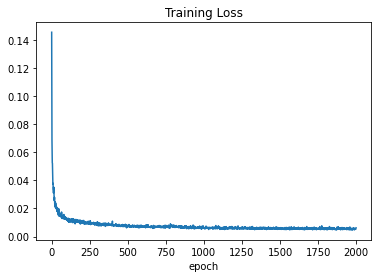

In [ ]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

## 4.7 모델 평가

In [ ]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서
    actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서
        
    with torch.no_grad():
        model.eval() # 평가를 할 때에는 .eval() 반드시 사용해야 한다.
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0) # cat을 통해 예측값을 누적
            actual = torch.cat((actual, values), 0) # cat을 통해 실제값을 누적

    rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용하여 RMSE 계산
    
    return rmse  

# 평가 시 .eval()을 사용해야 하는 이유
# 평가 시에는 온전한 모델로 평가를 해야하는데 .eval()이 아닌 .train()인 경우 드랍아웃이 활성화 되어 있다.
# 따라서 드랍아웃이나 배치 정규화 등과 같이 학습 시에만 사용하는 기술들을 평가 시에는 비활성화 해야만 한다.

In [ ]:
checkpoint = torch.load ('./models/4-4reg.pt')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
train_rmse = evaluation(trainloader) # 학습 데이터의 RMSE
test_rmse = evaluation(testloader) # 시험 데이터의 RMSE

print("Train RMSE: ",train_rmse)
print("Test RMSE: ",test_rmse)

# 예시를 위한 단순 비교입니다. 실제 연구에서는 디테일한 비교가 필요합니다.
# 20번의 평가 결과의 평균으로 결과값을 산정 했습니다.
# 데이터를 무작위로 나누고 모델의 초기값도 random initial parameter를 사용했기 때문에 학습을 할 때 마다 결과가 다르게 나올 수 있습니다.
# 이 강의에서는 학습의 흐름(for문)과 모델(Regressor) 부분을 주의 깊게 보시면 됩니다.

Train RMSE:  0.06467417
Test RMSE:  0.11265644
